In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from scipy import stats
import statsmodels.stats.multitest as smm
from mpl_toolkits.mplot3d import Axes3D


### Load and Process Data

In [ ]:
with open('Data/cleaned_data.csv') as file:
    read_file = csv.reader(file)
    Data = list(line for line in read_file)
file.close()

In [ ]:
Sample_Names = Data[0]
Site_Names = list(line[0] for line in Data[1:])
Beta_Matrix = list(list(map(float, line[1:])) for line in Data[1:])
beta_value= np.stack(Beta_Matrix)

In [4]:
m_value = np.log2(beta_value/(1 - beta_value))

In [6]:
with open('Data/bmi.csv') as file:
    read_file = csv.reader(file)
    bmi_l = list(line for line in read_file)
file.close()

with open('Data/age.csv') as file:
    read_file = csv.reader(file)
    age_l = list(line for line in read_file)
file.close()

with open('Data/smoking_status.csv') as file:
    read_file = csv.reader(file)
    ss_l = list(line for line in read_file)
file.close()

In [6]:
bmi = np.array(list(item[1] for item in bmi_l)[1:]).astype(float)
age = np.array(list(item[1] for item in age_l)[1:]).astype(float)
ss = np.array(list(item[1] for item in ss_l)[1:]).astype(float)

In [7]:
#To construct a independent variable matrix with 1, age, bmi, smoking_status 1 and 2 as the five features 
#(smoking status 0 dropped so matrix invertible)

enc = OneHotEncoder()
enc.fit(np.expand_dims(np.unique(ss),1))
new_ss = enc.transform(np.expand_dims(ss, 1)).toarray()
X = np.hstack([np.vstack([np.ones(bmi.shape[0]), age, bmi]).T, new_ss[:,1:]])

In [11]:
%load_ext ipycache

/Users/Jun/anaconda/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/Jun/anaconda/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [12]:
%%cache matrix_cache.pkl sample_id site_id beta_values m_values X
sample_id = Sample_Names
site_id = Site_Names
beta_values = beta_value
m_values = m_value
X = X


[Skipped the cell's code and loaded variables X, beta_values, m_values, sample_id, site_id from file '/Users/Jun/Documents/Fall 2017/Capstone/Capstone-githup/Linear Model/matrix_cache.pkl'.]


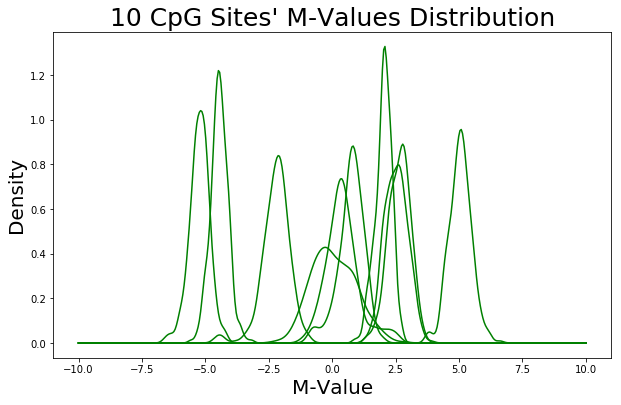

In [31]:
fig = plt.figure(figsize=[10,6])
plot = fig.add_subplot(111)

m_range = np.linspace(-10,10,400)
for i in np.random.randint(0,len(m_values), 10):
    density = gaussian_kde(m_values[i])
    #density.covariance_factor = lambda : .25
    #density._compute_covariance()
    plt.plot(m_range, density(m_range),'g')
plt.title('10 CpG Sites\' M-Values Distribution', fontsize = 25)
plt.xlabel('M-Value', fontsize = 20)
plt.ylabel('Density', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

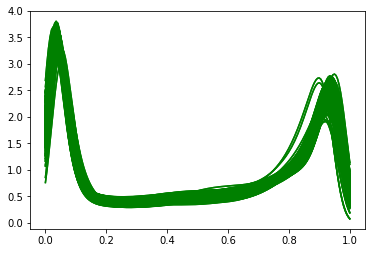

In [20]:
beta_range = np.linspace(0,1,200)
for i in range(beta_values.shape[1]):
    density = gaussian_kde(beta_values[:,i])
    #density.covariance_factor = lambda : .25
    #density._compute_covariance()
    plt.plot(beta_range, density(beta_range),'g')
plt.show()

In [140]:
def fit_lr(X, m_values):
    true_coef = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(m_values.T)
    return true_coef



In [160]:
def calculation(coef, X, m_values):
    y_predict = X.dot(coef)
    mse = np.sum((y_predict - m_values.T)**2 , axis = 0)/ float(X.shape[0] - X.shape[1])
    """
    standard error is the square root of the variance of the estimate, which is the element in the diagnol of
    the covariance matrix of the estimate. Use MSE as the estimated value of variance of the error. 
    """
    se = np.array([np.sqrt(np.diagonal(mse[i] * np.linalg.inv(np.dot(X.T, X)) )) for i in range(mse.shape[0])]) 
    t_m = coef.T/ se
    p_m = 2 * (1 - stats.t.cdf(np.abs(t_m), X.shape[0] - X.shape[1]))

    msr = np.sum((y_predict - np.mean(m_values.T, axis =0))**2, axis = 0) / float(X.shape[1] - 1)
    f_m = msr / mse
    pf_m = 1 - stats.f.cdf(np.abs(f_m), X.shape[1] -1, X.shape[0] - X.shape[1])

    return p_m, pf_m



In [129]:
def significance(p, p_signif = 0.01, alpha = 0.05, method = 'fdr_tsbh'):
    pval_corr = smm.multipletests(p, alpha=alpha, method=method)[1]
    fdr = np.where(pval_corr < p_signif)
    return fdr

### Linear Regression 

$$ CpG = \beta_0 + \beta_{age} * X_{age} +  \beta_{bmi} * X_{bmi} +  \beta_{ss1} * X_{ss1} +  \beta_{ss1} * X_{ss1}$$

Using False Discovery Rate - BH adjusted t-statiscs value to judge if a parameter is significant or not.

In [203]:
coef = fit_lr(X, m_values)
p, pf = calculation(coef, X, m_values)

In [204]:
Sig_sites = []
for i in range(1, p.shape[1]):
    Sig_sites.append(significance(p[:,i], p_signif = 0.05))

In [205]:
## Result: list of significant sites
Sig_sites

[(array([   157,    423,    554, ..., 450331, 450411, 450432]),),
 (array([   381,    751,    953, ..., 450377, 450397, 450412]),),
 (array([ 62200,  79810, 112013, 134072, 350126]),),
 (array([62200]),)]

### Interactive Regression 

$$ CpG = \beta_0 + \beta_{age} * X_{age} +  \beta_{bmi} * X_{bmi} +  \beta_{ss1} * X_{ss1} +  \beta_{ss1} * X_{ss1} +  \beta_{age^2} * X_{age^2} +  \beta_{age*bmi} * X_{age*bmi} +  \beta_{bmi^2} * X_{bmi^2}  $$

Using False Discovery Rate - BH adjusted t-statiscs value to judge if a parameter is significant or not.

Judging from the result not really meaningful 

In [181]:
poly = PolynomialFeatures(2) #, interaction_only=True
X_interact = poly.fit_transform(X[:,1:])


In [249]:
Col_names = ['intersect','age', 'bmi', 'ss-1', 'ss-2', 'age**2', 'age*bmi','age*ss1','age*ss2','bmi**2','bmi*ss1','bmi*ss2','ss1**2','ss1*ss2','ss2**2']

## Exclude all SS1 and SS2
## Don't need the ss interaction vectors --> cause linearity
col = [0,1,2,3,4,6,7,8,10,11]
X_int = X_interact[:,col]
col_names = [Col_names[i] for i in col]
print("Columns selected: %s" %(col_names))

Columns selected: ['intersect', 'age', 'bmi', 'ss-1', 'ss-2', 'age*bmi', 'age*ss1', 'age*ss2', 'bmi*ss1', 'bmi*ss2']


In [250]:
coef_int = fit_lr(X_int, m_values)
p_int, pf_int = calculation(coef_int, X_int, m_values)


In [253]:
Sig_sites_int = []
for i in range(1, p_int.shape[1]):
    Sig_sites_int.append(significance(p_int[:,i], p_signif = 0.1,  alpha = 0.1))

for i in range(1, p_int.shape[1]):
    print('Significant %s sites: %s'%(col_names[i] , Sig_sites_int[i-1]))
    print([site_id[j] for  j in Sig_sites_int[i-1][0]])
#     temp = np.where(p_int[:,i] < 0.05)[0]
#     print('%s of significant %s sites: %s'%(len(temp), Col_names[i] , temp))



Significant age sites: (array([], dtype=int64),)
[]
Significant bmi sites: (array([277749]),)
['cg13485335']
Significant ss-1 sites: (array([187336]),)
['cg01284326']
Significant ss-2 sites: (array([], dtype=int64),)
[]
Significant age*bmi sites: (array([277749]),)
['cg13485335']
Significant age*ss1 sites: (array([262569, 328816]),)
['cg25726414', 'cg05859760']
Significant age*ss2 sites: (array([], dtype=int64),)
[]
Significant bmi*ss1 sites: (array([ 23859,  47660,  75201,  79122,  98691, 117217, 158100, 187336,
       193963, 203914, 215963, 262569, 292318, 295208, 337290, 375473,
       385127, 430775]),)
['cg07833104', 'cg23590525', 'cg17459225', 'cg20961248', 'cg13515605', 'cg09237447', 'cg04368067', 'cg01284326', 'cg07424889', 'cg17893767', 'cg03385272', 'cg25726414', 'cg01094787', 'cg04427360', 'cg23005405', 'cg01899544', 'cg11856697', 'cg04343690']
Significant bmi*ss2 sites: (array([350284]),)
['cg21575308']


In [269]:
coef_int[:,277749]
# m_values.shape

array([ -8.83749600e+00,   1.66287120e-01,   4.34068047e-01,
        -1.77630486e-01,   3.49337129e+00,  -7.01623801e-03,
         1.23653648e-02,  -1.09577463e-02,  -2.22675843e-02,
        -1.05286813e-01])

In [266]:
np.savetxt('x_int.csv', X_int, delimiter=',') 
np.savetxt('m277749.csv', m_values[277749], newline='\n')

### Save Result

In [150]:
with open('result.csv', 'w', newline='\n') as file:
    for line in result:
        file.write(str(','.join(list(line))+'\n'))

### Visualization

In [68]:
ss_zero = np.where(np.sum(X[:,2:], axis =1) == 0)
ss_one = np.where(X[:,2] == 1)
ss_two = np.where(X[:,3] == 1)

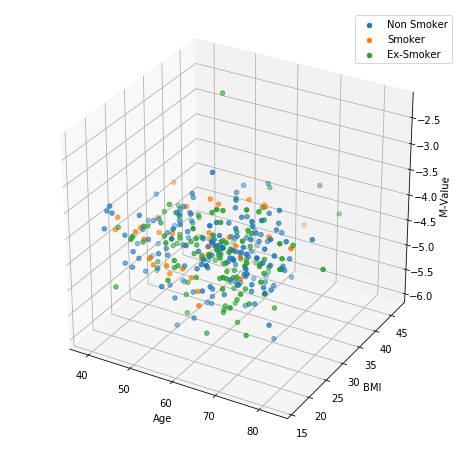

In [79]:
fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[ss_zero,0],X[ss_zero,1], m_values[0, ss_zero],label = 'Non Smoker')
ax.scatter(X[ss_one,0],X[ss_one,1], m_values[0, ss_one], label = 'Smoker')
ax.scatter(X[ss_two,0],X[ss_two,1], m_values[0, ss_two], label = 'Ex-Smoker')

ax.set_xlabel('Age')
ax.set_ylabel('BMI')
ax.set_zlabel('M-Value')
ax.legend()
plt.show()




In [10]:
np.bincount([int(ss_l[i][1]) for i in range(1, len(ss_l))])

array([158,  38, 126])